In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding,Conv1D, MaxPooling1D,Input,Concatenate,SimpleRNN
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model

In [5]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Download nltk library

In [6]:
nltk.download('wordnet', "/kaggle/working/nltk_data/")
nltk.download('omw-1.4', "/kaggle/working/nltk_data/")
! unzip /kaggle/working/nltk_data/corpora/wordnet.zip -d /kaggle/working/nltk_data/corpora
! unzip /kaggle/working/nltk_data/corpora/omw-1.4.zip -d /kaggle/working/nltk_data/corpora
nltk.data.path.append("/kaggle/working/nltk_data/")

[nltk_data] Downloading package wordnet to
[nltk_data]     /kaggle/working/nltk_data/...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /kaggle/working/nltk_data/...
Archive:  /kaggle/working/nltk_data/corpora/wordnet.zip
   creating: /kaggle/working/nltk_data/corpora/wordnet/
  inflating: /kaggle/working/nltk_data/corpora/wordnet/lexnames  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/data.verb  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/index.adv  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/index.verb  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/data.adj  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/index.adj  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/nltk_data/c

Read Dataset

In [7]:
data =pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv', encoding = 'latin',header=None)

In [8]:
data

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [9]:
data.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
data.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [10]:
data = data.drop(['id', 'date', 'query', 'user_id'], axis=1)
data

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


In [11]:
data['sentiment'].replace({4: 1}, inplace=True) # 0 for negative and 1 for positive sentiments
data

/tmp/ipykernel_34/745323715.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['sentiment'].replace({4: 1}, inplace=True) # 0 for negative and 1 for psitive sentiments


,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,1,Just woke up. Having no school is the best fee...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...


Visualization

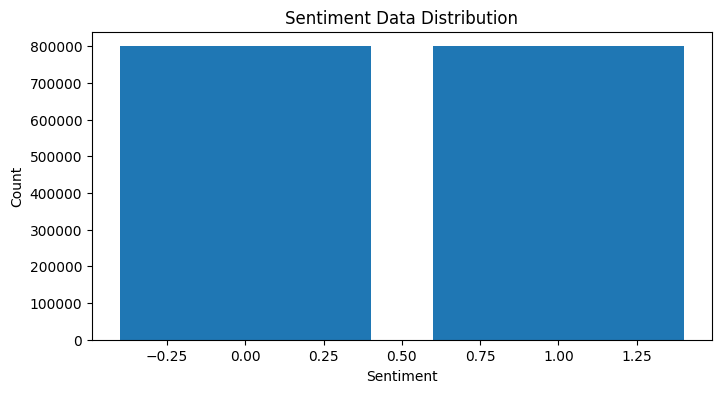

In [12]:
val_count = data.sentiment.value_counts()

# Plotting
plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Frequency')

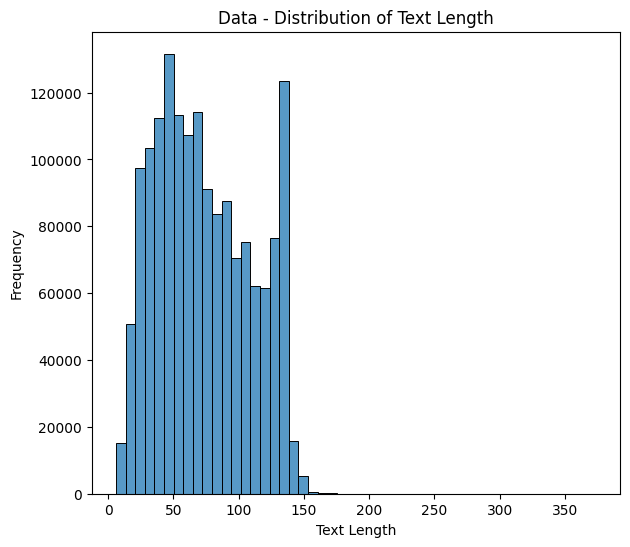

In [13]:
# Visualize a histogram of the text lengths for data
data['text_length'] = data['text'].apply(len)
plt.figure(figsize=(15,6))

plt.subplot(1, 2, 1)
sns.histplot(data['text_length'], bins=50)
plt.title('Data - Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

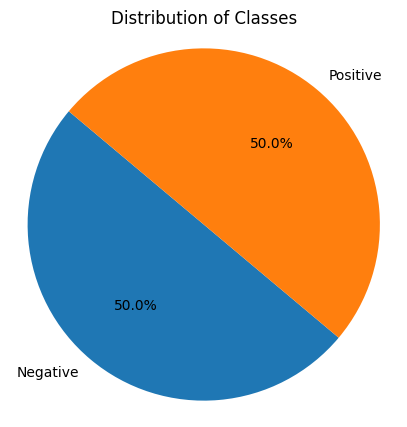

In [40]:
# Count the number of rows for each class
class_counts = data['sentiment'].value_counts()

# Plotting a pie chart
plt.figure(figsize=(5, 5))
plt.pie(class_counts, labels=['Negative', 'Positive'], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Classes')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

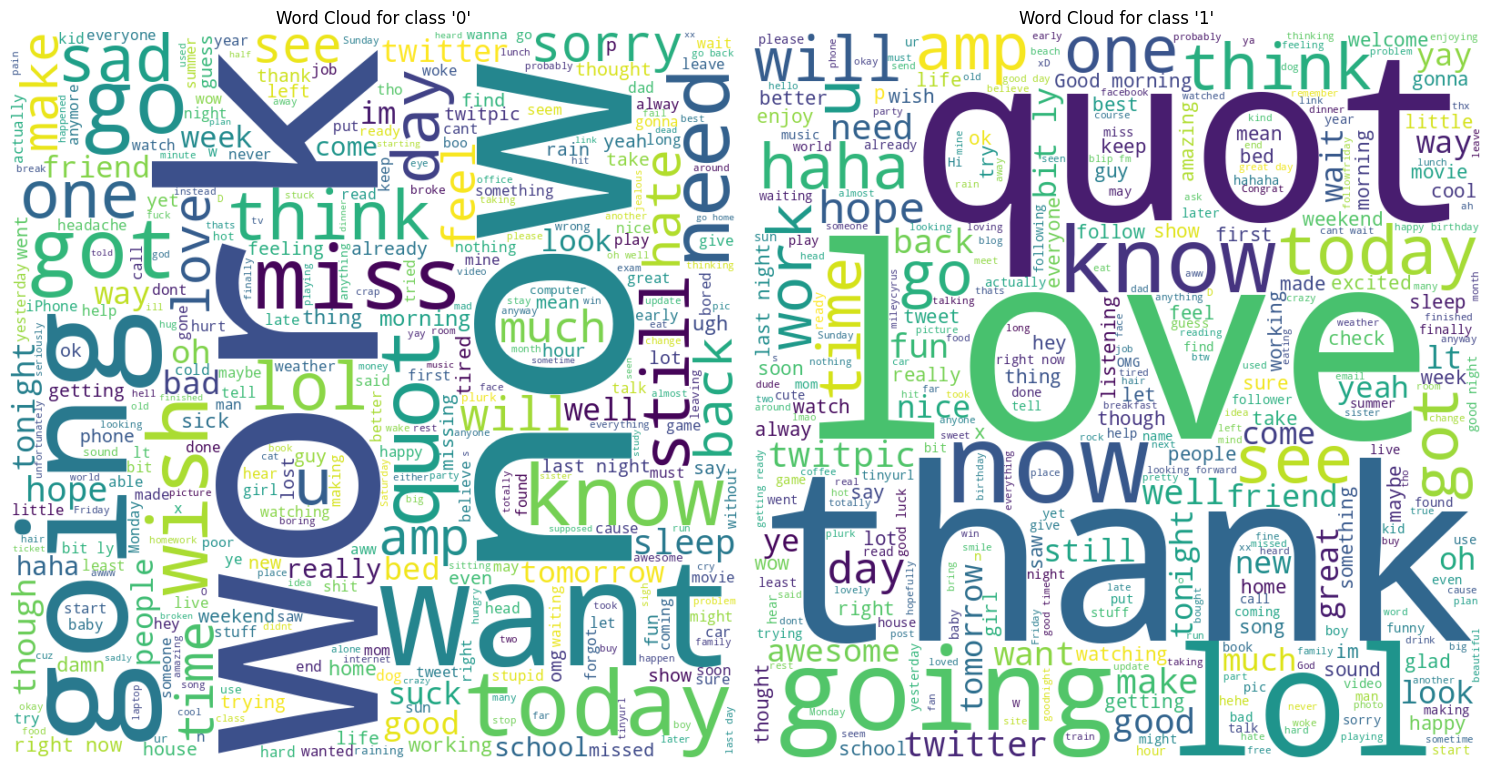

In [15]:
from wordcloud import WordCloud

# Function to generate word cloud for a specific class
def generate_wordcloud(text, ax, title):
    wordcloud = WordCloud(width=800, height=800, 
                          background_color='white', 
                          stopwords=None, 
                          max_words = 350,
                          min_font_size=10).generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(title)
    ax.axis("off")

# Generate word cloud for each class in subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 10))

for i, label in enumerate(data['sentiment'].unique()):
    text = ' '.join(data[data['sentiment'] == label]['text'])
    row = i // 2
    col = i % 2
    generate_wordcloud(text, axs[col], f"Word Cloud for class '{label}'")

plt.tight_layout()
plt.show()


In [16]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to preprocess text
def preprocess_text(text):
    # Convert text to lowercase and remove tags    
    text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenization
    words = word_tokenize(text)
    
    # Remove stopwords
    words = [word for word in words if word not in stop_words]
    
    # Lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

In [17]:
data['preprocessed_text'] = data['text'].apply(preprocess_text)
data

,sentiment,text,text_length,preprocessed_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",115,awww bummer shoulda got david carr third day
1,0,is upset that he can't update his Facebook by ...,111,upset update facebook texting might cry result...
2,0,@Kenichan I dived many times for the ball. Man...,89,dived many time ball managed save 50 rest go b...
3,0,my whole body feels itchy and like its on fire,47,whole body feel itchy like fire
4,0,"@nationwideclass no, it's not behaving at all....",111,behaving mad see
...,...,...,...,...
1599995,1,Just woke up. Having no school is the best fee...,56,woke school best feeling ever
1599996,1,TheWDB.com - Very cool to hear old Walt interv...,78,thewdb com cool hear old walt interview
1599997,1,Are you ready for your MoJo Makeover? Ask me f...,57,ready mojo makeover ask detail
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...,65,happy 38th birthday boo alll time tupac amaru ...


In [18]:
# Splits Dataset into Training and Testing set
train_data, test_data = train_test_split(data, test_size=0.2,random_state=100) 
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 1280000
Test Data size 320000


In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 595294


In [20]:
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text), maxlen = 80)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),maxlen = 80)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1280000, 80)
Testing X Shape: (320000, 80)


In [21]:
y_train = np.array(train_data['sentiment']).reshape(-1,1)
y_test = np.array(test_data['sentiment']).reshape(-1,1)
print("Training Y Shape:",y_train.shape)
print("Testing Y Shape:",y_test.shape)

Training Y Shape: (1280000, 1)
Testing Y Shape: (320000, 1)


In [24]:
print(x_train[0])

[     0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0  46131     72     53    447      2
    689     91     10 196578      9    800     16    100    126   1285]


In [25]:
embedding_layer = Embedding(vocab_size,100,input_length=80,trainable=False)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [26]:
print(x_train.shape,y_train.shape)

(1280000, 80) (1280000, 1)


Build Models

1 - Simple RNN Without CNN

In [67]:
from tensorflow.keras.layers import SimpleRNN

# Define the model
sequence_input = Input(shape=(80,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SimpleRNN(64, dropout=0.2, recurrent_dropout=0.2)(embedding_sequences)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = Model(sequence_input, outputs)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, batch_size=64, epochs=5)

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


Epoch 1/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 156s 8ms/step - accuracy: 0.5059 - loss: 0.6930
Epoch 2/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 152s 8ms/step - accuracy: 0.5701 - loss: 0.6768
Epoch 3/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 152s 8ms/step - accuracy: 0.5805 - loss: 0.6726
Epoch 4/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 152s 8ms/step - accuracy: 0.5851 - loss: 0.6720
Epoch 5/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 152s 8ms/step - accuracy: 0.5820 - loss: 0.6738
   60/10000 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.6246 - loss: 0.6575    

W0000 00:00:1714218565.264723     870 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10000/10000 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.6129 - loss: 0.6610
Test Loss: 0.6614127159118652
Test Accuracy: 0.6122499704360962


2 - Simple RNN and  Simple CNN Architecture

In [68]:
# Define the model
sequence_input = Input(shape=(80,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x1 = Conv1D(64, 5, activation='relu')(embedding_sequences)
x1 = MaxPooling1D(pool_size=4)(x1)
x1 = SimpleRNN(64, dropout=0.2, recurrent_dropout=0.2)(x1)
x1 = Dense(512, activation='relu')(x1)
x1 = Dense(512, activation='relu')(x1)
outputs = Dense(1, activation='sigmoid')(x1)
model_cnn = Model(sequence_input, outputs)

# Compile the model
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model_cnn.fit(x_train, y_train, batch_size=64, epochs=5)

# Evaluate the model
loss, accuracy = model_cnn.evaluate(x_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Epoch 1/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 75s 3ms/step - accuracy: 0.6975 - loss: 0.5641
Epoch 2/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step - accuracy: 0.7628 - loss: 0.4874
Epoch 3/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 69s 3ms/step - accuracy: 0.7730 - loss: 0.4733
Epoch 4/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 70s 3ms/step - accuracy: 0.7785 - loss: 0.4648
Epoch 5/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 70s 3ms/step - accuracy: 0.7815 - loss: 0.4600
   87/10000 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.7871 - loss: 0.4467    

W0000 00:00:1714219069.685066     871 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10000/10000 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.7859 - loss: 0.4560
Test Loss: 0.45627832412719727
Test Accuracy: 0.7852625250816345


3 - Simple RNN and CNN Architecture ( VGG16 )

In [69]:
# Define the model VGG16
sequence_input = Input(shape=(80,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)

x2 = Embedding(input_dim=vocab_size, output_dim=100, input_length=80)(sequence_input)

x2 = Conv1D(64, 3, activation='relu', padding='same')(x2)
x2 = Conv1D(64, 3, activation='relu', padding='same')(x2)
x2 = MaxPooling1D(2)(x2)

x2 = Conv1D(128, 3, activation='relu', padding='same')(x2)
x2 = Conv1D(128, 3, activation='relu', padding='same')(x2)
x2 = MaxPooling1D(2)(x2)

x2 = Conv1D(256, 3, activation='relu', padding='same')(x2)
x2 = Conv1D(256, 3, activation='relu', padding='same')(x2)
x2 = Conv1D(256, 3, activation='relu', padding='same')(x2)
x2 = MaxPooling1D(2)(x2)

x2 = Conv1D(512, 3, activation='relu', padding='same')(x2)
x2 = Conv1D(512, 3, activation='relu', padding='same')(x2)
x2 = Conv1D(512, 3, activation='relu', padding='same')(x2)
x2 = MaxPooling1D(2)(x2)

x2 = Conv1D(512, 3, activation='relu', padding='same')(x2)
x2 = Conv1D(512, 3, activation='relu', padding='same')(x2)
x2 = Conv1D(512, 3, activation='relu', padding='same')(x2)
x2 = MaxPooling1D(2)(x2)

x2 = Flatten()(x2)
x2 = Dense(512, activation='relu')(x2)
x2 = Dense(512, activation='relu')(x2)

outputs = Dense(1, activation='sigmoid')(x2)

model_vgg16 = Model(sequence_input, outputs)

# Compile the model
model_vgg16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model_vgg16.fit(x_train, y_train, batch_size=64, epochs=5)

# Evaluate the model
loss, accuracy = model_vgg16.evaluate(x_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
    5/20000 ━━━━━━━━━━━━━━━━━━━━ 11:57 36ms/step - accuracy: 0.4253 - loss: 0.6934

W0000 00:00:1714219207.669076     871 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20000/20000 ━━━━━━━━━━━━━━━━━━━━ 578s 28ms/step - accuracy: 0.4993 - loss: 0.6932
Epoch 2/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 566s 28ms/step - accuracy: 0.4994 - loss: 0.6932
Epoch 3/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 566s 28ms/step - accuracy: 0.5001 - loss: 0.6932
Epoch 4/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 566s 28ms/step - accuracy: 0.4995 - loss: 0.6932
Epoch 5/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 564s 28ms/step - accuracy: 0.5005 - loss: 0.6932
   52/10000 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.4948 - loss: 0.6932 

W0000 00:00:1714222038.234597     873 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10000/10000 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - accuracy: 0.4987 - loss: 0.6932
Test Loss: 0.6931713819503784
Test Accuracy: 0.49864375591278076


4 - Simple RNN and CNN Architecture ( Inception Modules )

Epoch 1/5
   14/16000 ━━━━━━━━━━━━━━━━━━━━ 3:18 12ms/step - accuracy: 0.4923 - loss: 0.7518

W0000 00:00:1714318077.848582     187 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


15997/16000 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7325 - loss: 0.5210

W0000 00:00:1714318221.866165     189 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


16000/16000 ━━━━━━━━━━━━━━━━━━━━ 156s 10ms/step - accuracy: 0.7325 - loss: 0.5210 - val_accuracy: 0.7846 - val_loss: 0.4525
Epoch 2/5
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 152s 9ms/step - accuracy: 0.7978 - loss: 0.4321 - val_accuracy: 0.7931 - val_loss: 0.4397
Epoch 3/5
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 152s 9ms/step - accuracy: 0.8211 - loss: 0.3934 - val_accuracy: 0.7911 - val_loss: 0.4509
Epoch 4/5
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 152s 9ms/step - accuracy: 0.8494 - loss: 0.3448 - val_accuracy: 0.7851 - val_loss: 0.4740
Epoch 5/5
16000/16000 ━━━━━━━━━━━━━━━━━━━━ 152s 9ms/step - accuracy: 0.8785 - loss: 0.2886 - val_accuracy: 0.7787 - val_loss: 0.5113
   82/10000 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.7964 - loss: 0.5044    

W0000 00:00:1714318838.247529     188 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10000/10000 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.7813 - loss: 0.5092
Test Loss: 0.5078822374343872
Test Accuracy: 0.7806156277656555


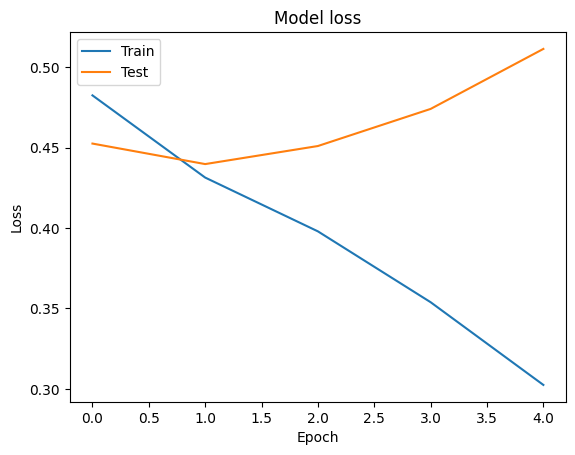

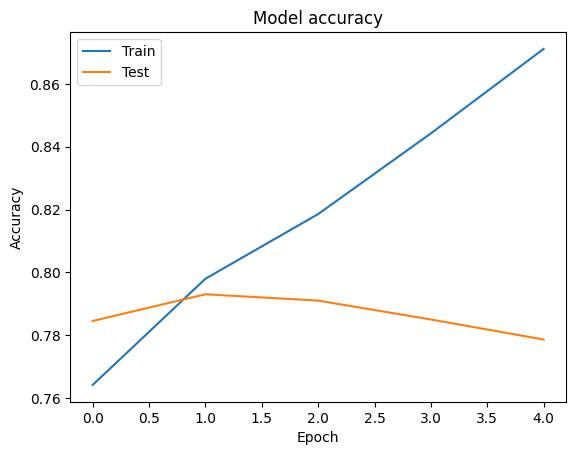

In [28]:

# Define the model
sequence_input = Input(shape=(80,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)

x1 = Conv1D(64, 1, activation='relu', padding='same')(embedding_sequences)
x2 = Conv1D(64, 3, activation='relu', padding='same')(embedding_sequences)
x3 = Conv1D(64, 5, activation='relu', padding='same')(embedding_sequences)
x4 = Conv1D(64, 7, activation='relu', padding='same')(embedding_sequences)
x5 = Conv1D(64, 9, activation='relu', padding='same')(embedding_sequences)
x6 = MaxPooling1D(pool_size=3, strides=1, padding='same')(embedding_sequences)
x6 = Conv1D(64, 1, activation='relu', padding='same')(x6)

x = Concatenate(axis=-1)([x1, x2, x3, x4, x5, x6])

x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)

outputs = Dense(1, activation='sigmoid')(x)

model_inception = Model(sequence_input, outputs)

# Compile the model
model_inception.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model_inception.fit(x_train, y_train, batch_size=64, epochs=5,validation_split=0.2)

# Evaluate the model
loss, accuracy = model_inception.evaluate(x_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


Result Of All Models ( Accuracy ) \n
1 - Simple RNN Without CNN --> 61.22 %
2 - Simple RNN and Simple CNN Architecture --> 78.52 %
3 - Simple RNN and CNN Architecture ( VGG16 ) --> 49.86%
4 - Simple RNN and CNN Architecture ( Inception Modules ) --> 78.06

In [29]:
def predict_sentiment(model, text):
    preprocessed_text = preprocess_text(text)
    sequence = tokenizer.texts_to_sequences([preprocessed_text])
    padded_sequence = pad_sequences(sequence, maxlen=80)
    prediction = model.predict(padded_sequence)[0][0]
    if prediction >= 0.5:
        return "Positive"
    else:
        return "Negative"

In [30]:
# Example usage
sentence = "I really liked this movie, it was fantastic!"
predicted_label = predict_sentiment(model_inception, sentence)
print("Predicted Label:", predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Label: Positive


In [31]:
sentence = "Today AI and ML become good for this days"
predicted_label = predict_sentiment(model_inception, sentence)
print("Predicted Label:", predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Label: Positive


In [34]:
sentence = "AI is more difficult and bad in this days"
predicted_label = predict_sentiment(model_inception, sentence)
print("Predicted Label:", predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted Label: Negative


In [36]:
sentence = "we worry from animals "
predicted_label = predict_sentiment(model_inception, sentence)
print("Predicted Label:", predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Label: Positive


   91/10000 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step    

W0000 00:00:1714319111.019882     190 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10000/10000 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step


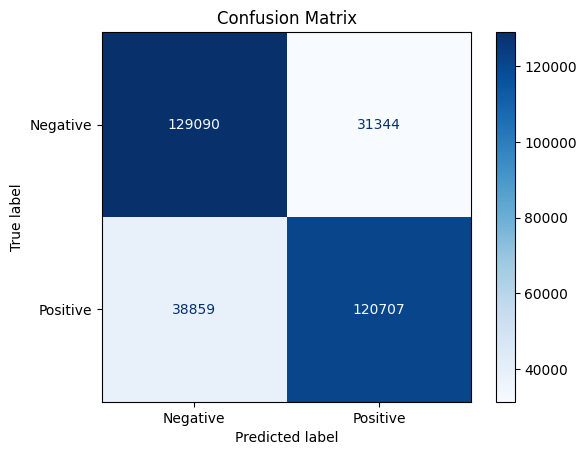

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions
y_pred = model_inception.predict(x_test)
y_pred = (y_pred > 0.5)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()



In [38]:
from sklearn.metrics import classification_report


# Print classification report
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))


              precision    recall  f1-score   support

    Negative       0.77      0.80      0.79    160434
    Positive       0.79      0.76      0.77    159566

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000

